In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import glob

In [13]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [14]:
# Define the custom dataset
class CatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith('.jpg'):
                        self.image_files.append(os.path.join(folder_path, file))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Load annotations
        anno_path = img_path + '.cat'
        with open(anno_path, 'r') as f:
            anno = f.readline().strip().split()[1:]
        anno = torch.tensor([float(x) for x in anno])
        
        return image, anno


In [15]:
class CatDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(image_dir, '**/*.jpg'), recursive=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        
        annotation_path = img_path + '.cat'
        with open(annotation_path, 'r') as f:
            annotations = list(map(int, f.readline().split()[1:]))
        
        original_width, original_height = img.size
        target_width, target_height = 64, 64
        
        # Scale annotations
        annotations[0::2] = [x * (target_width / original_width) for x in annotations[0::2]]
        annotations[1::2] = [y * (target_height / original_height) for y in annotations[1::2]]
        
        annotations = torch.tensor(annotations)
        
        if self.transform:
            img = self.transform(img)
        
        return img, annotations

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [16]:
# Set up data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


In [17]:
image_dir = "C:/Users/osyed/OneDrive/Desktop/AIML Assessment project"
dataset = CatDataset(image_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


Sample Image Dimensions (HxW): 64 64
Sample Annotations: tensor([29.8667, 20.4800, 40.7893, 20.7360, 33.9627, 25.4720, 25.4293, 15.4880,
        23.3813,  9.9840, 28.3307, 11.9040, 47.9573, 12.9280, 53.2480, 12.2880,
        50.5173, 17.0240])


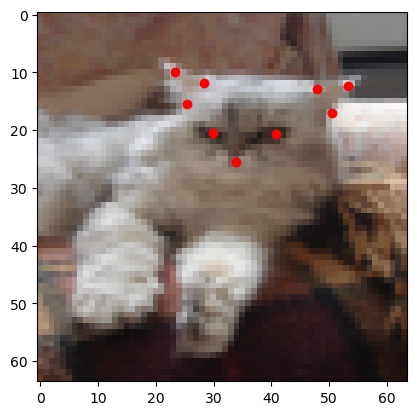

In [18]:
# Visualize a sample image and its annotations
sample_img, sample_annotations = dataset[0]

print("Sample Image Dimensions (HxW):", sample_img.shape[1], sample_img.shape[2])
print("Sample Annotations:", sample_annotations)

plt.imshow(sample_img.permute(1, 2, 0))
plt.scatter(sample_annotations[0::2], sample_annotations[1::2], c='red')
plt.show()

In [19]:
# Initialize the VAE model
latent_dim = 100
vae = VAE(latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=4096, out_features=100, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=100, bias=True)
  (decoder_input): Linear(in_features=100, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2

In [20]:
# Define the loss function and optimizer
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

Epoch [1/5], Train Loss: 7317.6078, Val Loss: 7044.7408


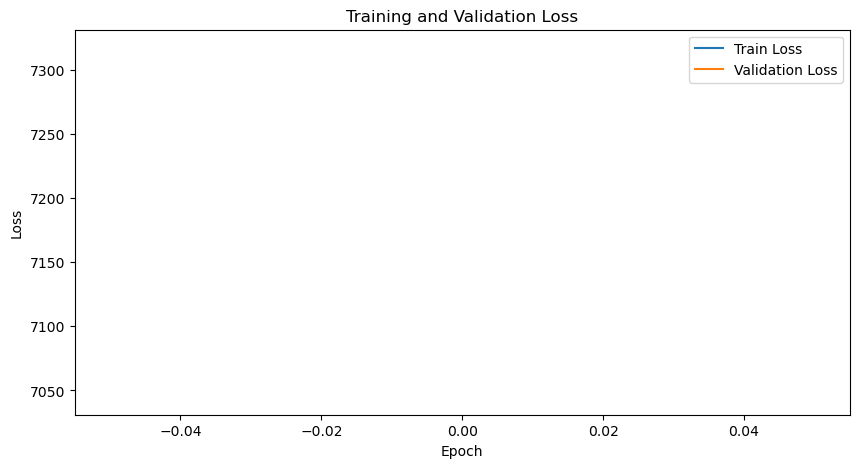

Epoch [2/5], Train Loss: 7000.4707, Val Loss: 6954.5054


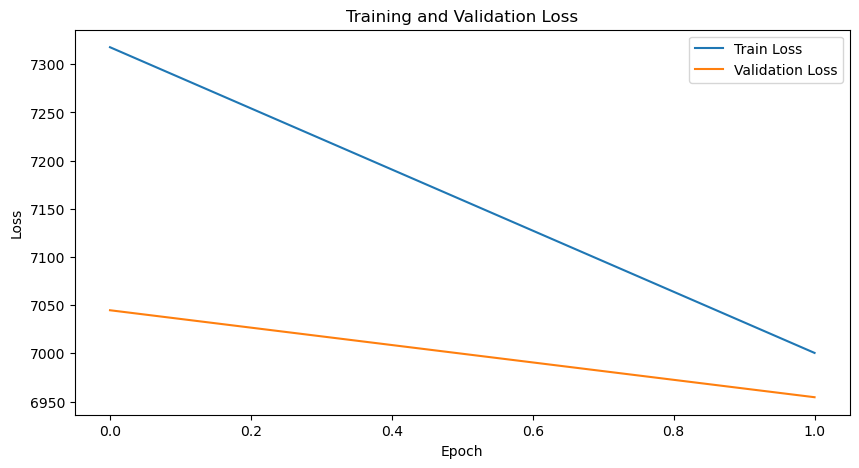

Epoch [3/5], Train Loss: 6899.9552, Val Loss: 6862.6781


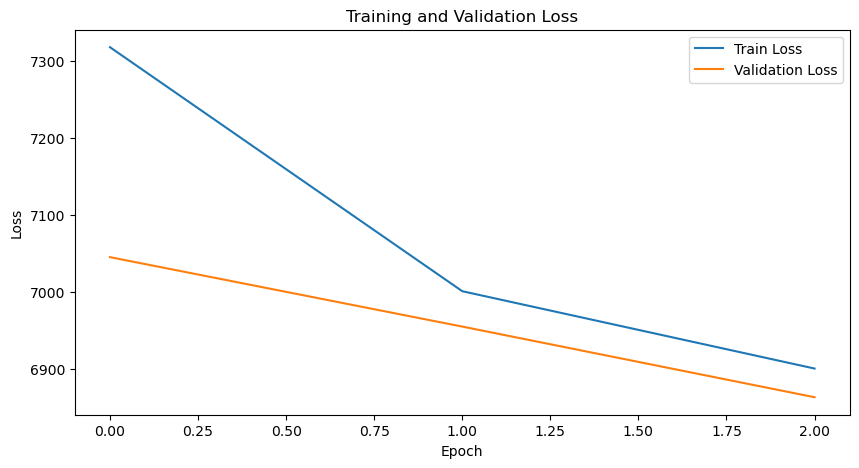

Epoch [4/5], Train Loss: 6855.7095, Val Loss: 6849.9984


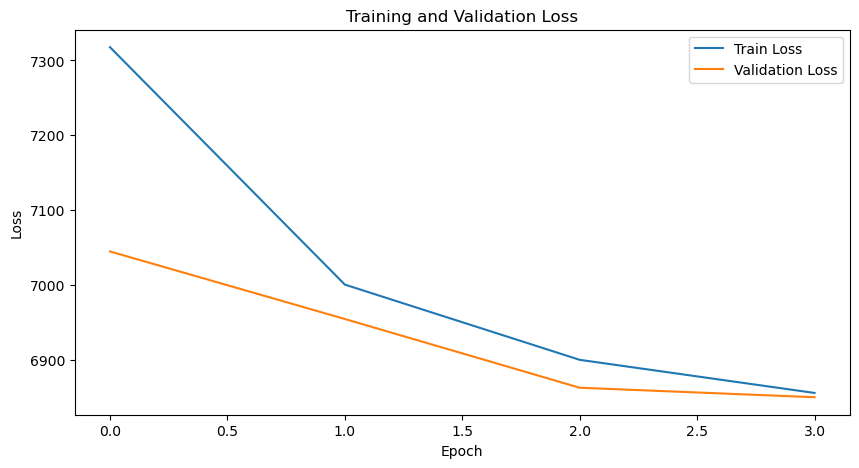

Epoch [5/5], Train Loss: 6838.2846, Val Loss: 6851.0217


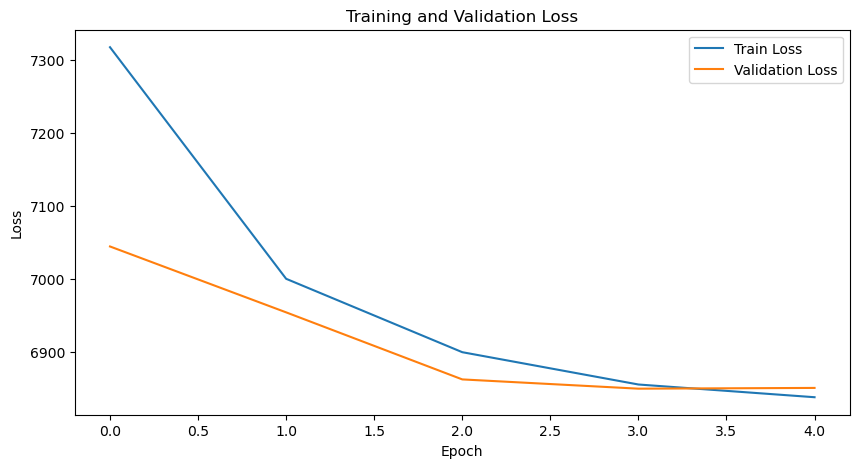

In [21]:
# Training loop
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_train_loss = train_loss / len(data_loader.dataset)
    train_losses.append(avg_train_loss)
    
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mu, logvar = vae(data)
            val_loss += loss_function(recon_batch, data, mu, logvar).item()
    
    avg_val_loss = val_loss / len(data_loader.dataset)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    # Generate and display a sample image
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            sample = torch.randn(1, latent_dim).to(device)
            generated_img = vae.decode(sample).cpu().squeeze(0)
            plt.figure(figsize=(8, 8))
            plt.imshow(generated_img.permute(1, 2, 0))
            plt.title(f'Generated Cat Image (Epoch {epoch+1})')
            plt.axis('off')
            plt.show()


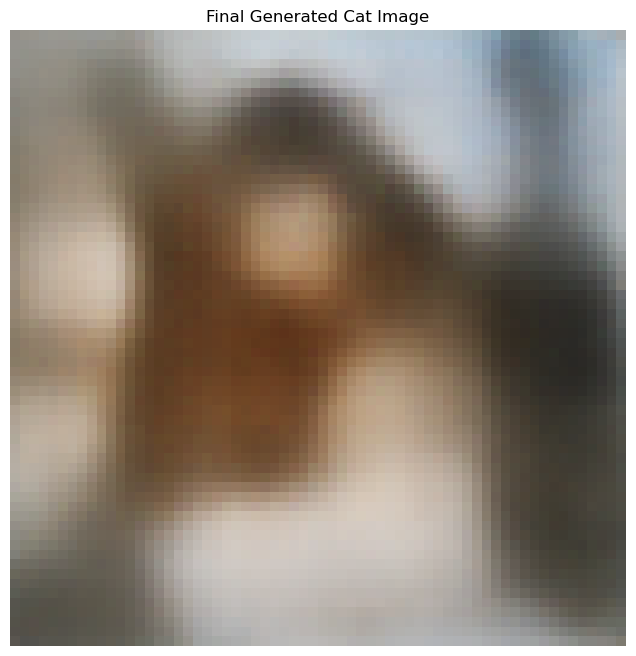

In [25]:
# Generate final cat image
vae.eval()
with torch.no_grad():
    sample = torch.randn(1, latent_dim).to(device)
    generated_img = vae.decode(sample).cpu().squeeze(0)
    plt.figure(figsize=(8, 8))
    plt.imshow(generated_img.permute(1, 2, 0))
    plt.title('Final Generated Cat Image')
    plt.axis('off')
    plt.show()

In [26]:
# Define a function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [27]:
# Define a function to load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [28]:
# Save the model after initial training
save_model(vae, 'vae_model.pth')

Epoch [6/10], Train Loss: 6824.2237, Val Loss: 6820.6075


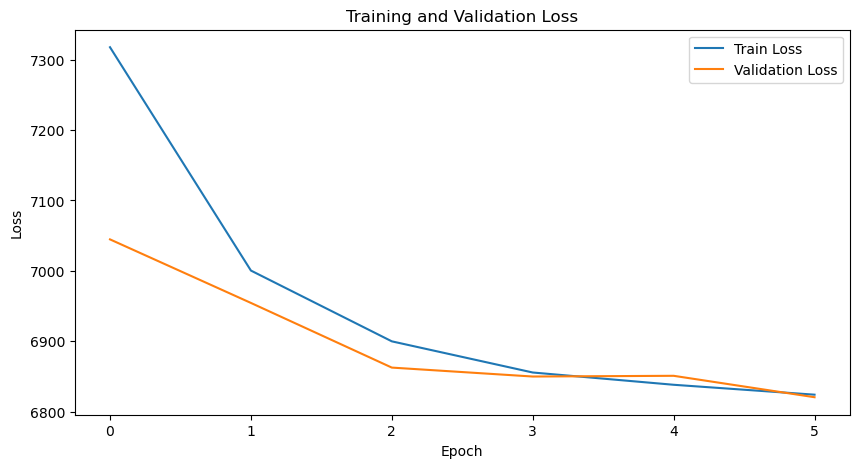

Epoch [7/10], Train Loss: 6815.2499, Val Loss: 6808.6322


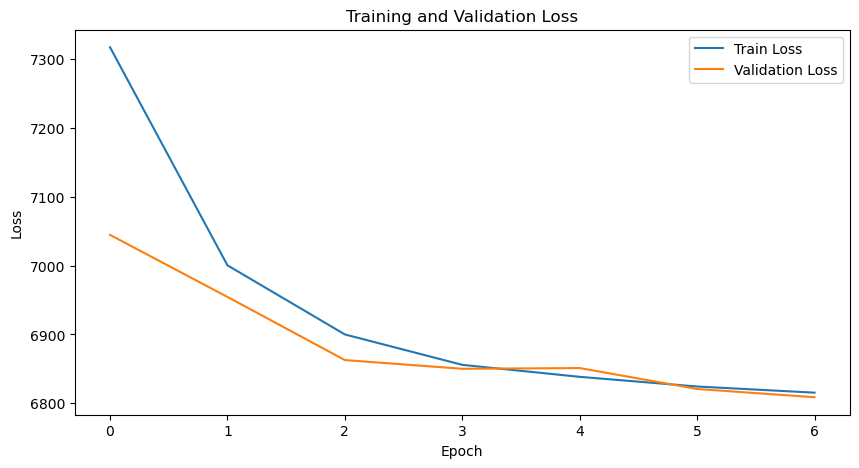

Epoch [8/10], Train Loss: 6808.4625, Val Loss: 6806.8758


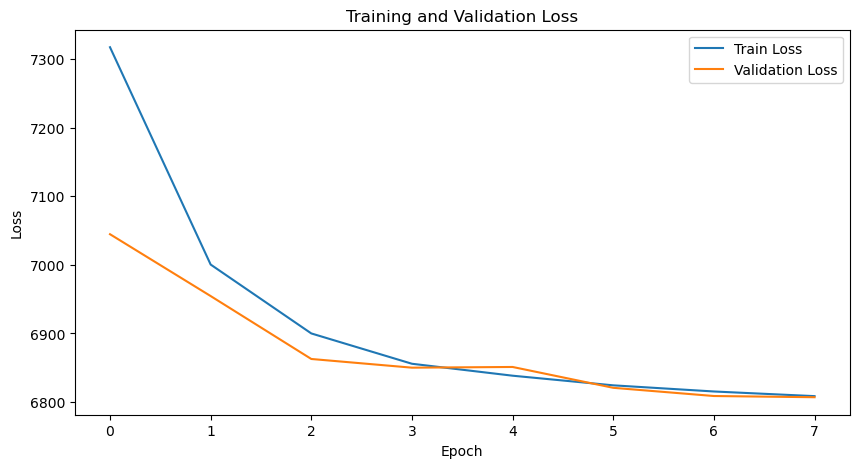

Epoch [9/10], Train Loss: 6801.0873, Val Loss: 6794.4066


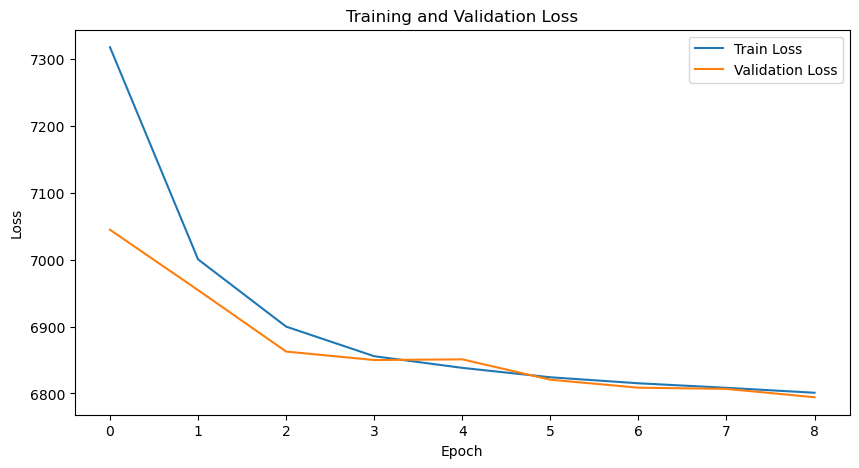

Epoch [10/10], Train Loss: 6793.8529, Val Loss: 6784.1638


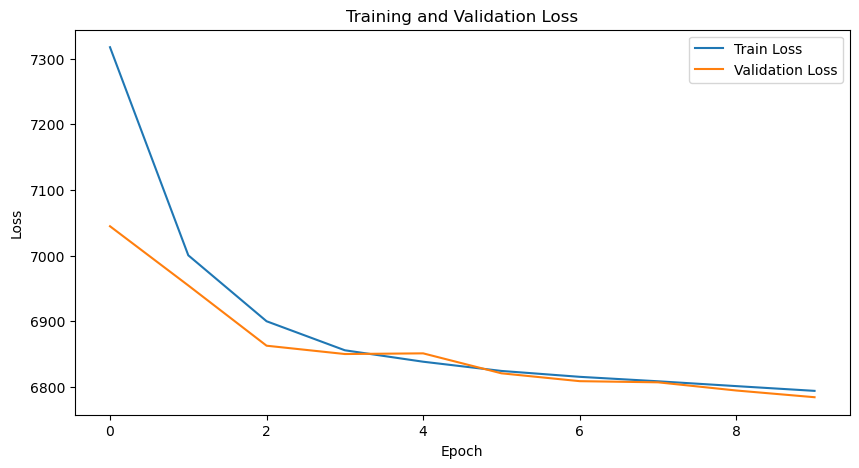

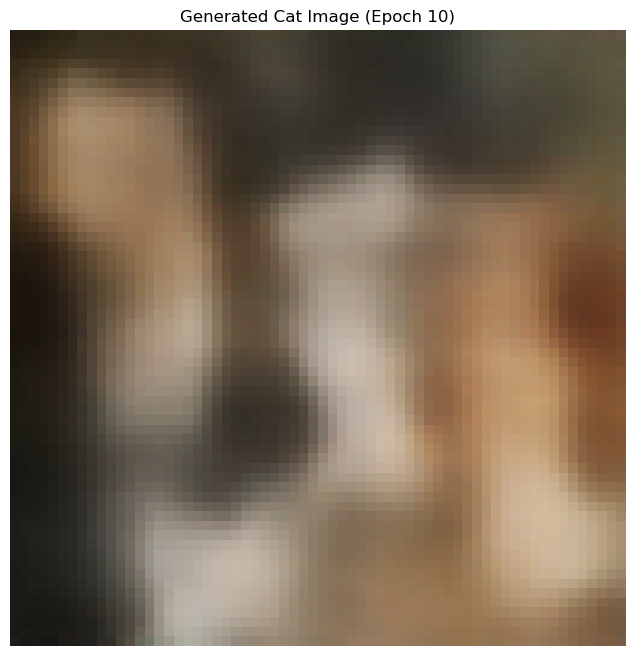

In [29]:
# To continue training for additional epochs
num_additional_epochs = 5

for epoch in range(num_epochs, num_epochs + num_additional_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_train_loss = train_loss / len(data_loader.dataset)
    train_losses.append(avg_train_loss)
    
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mu, logvar = vae(data)
            val_loss += loss_function(recon_batch, data, mu, logvar).item()
    
    avg_val_loss = val_loss / len(data_loader.dataset)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs + num_additional_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Generate and display a sample image
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            sample = torch.randn(1, latent_dim).to(device)
            generated_img = vae.decode(sample).cpu().squeeze(0)
            plt.figure(figsize=(8, 8))
            plt.imshow(generated_img.permute(1, 2, 0))
            plt.title(f'Generated Cat Image (Epoch {epoch+1})')
            plt.axis('off')
            plt.show()

# Save the model after additional training
save_model(vae, 'vae_model_continued.pth')

In [30]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the VAE model (ensure this matches your previously defined VAE model)
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(start_dim=1, end_dim=-1)
        )
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 4096)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z).view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [31]:
# Set the latent dimension and device
latent_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [32]:
# Initialize the model and load the weights
vae = VAE(latent_dim)
vae.to(device)
vae.load_state_dict(torch.load('vae_model_continued.pth'))
vae.eval()



VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=4096, out_features=100, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=100, bias=True)
  (decoder_input): Linear(in_features=100, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2

In [41]:
# Generate a new cat image
with torch.no_grad():
    sample = torch.randn(1, latent_dim).to(device)
    generated_img = vae.decode(sample).cpu().squeeze(0)



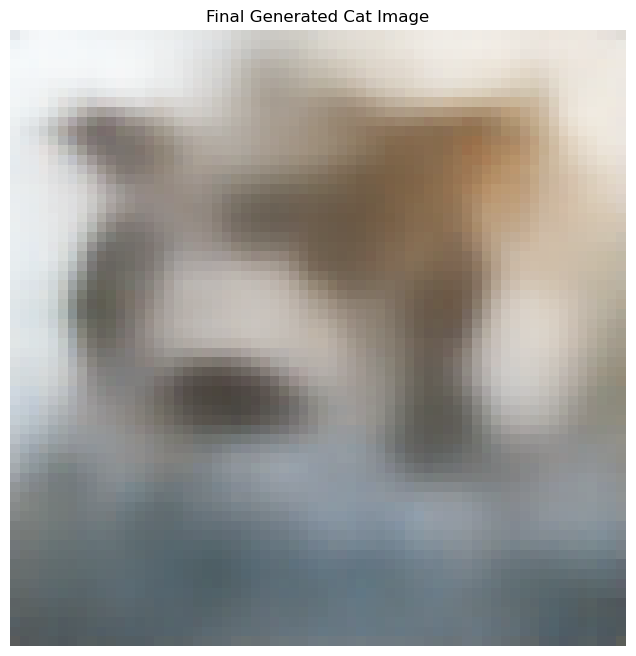

In [42]:
# Display the generated image
plt.figure(figsize=(8, 8))
plt.imshow(generated_img.permute(1, 2, 0))
plt.title('Final Generated Cat Image')
plt.axis('off')
plt.show()